# Section 1.2: Dimension reduction and principal component analysis (PCA)

One of the iron laws of data science is know as the "curse of dimensionality": as the number of considered features (dimensions) of a feature space increases, the number of data configurations can grow exponentially and thus the number observations (data points) needed to account for these configurations must also increase. Because this fact of life has huge ramifications for the time, computational effort, and memory required it is often desirable to reduce the number of dimensions we have to work with.

One way to accomplish this is by reducing the number of features considered in an analysis. After all, not all features are created equal, and some yield more insight for a given analysis than others. While this type of feature engineering is necessary in any data-science project, we can really only take it so far; up to a point, considering more features can often increase the accuracy of a classifier. (For example, consder how many features could increase the accuracy of classifying images as cats or dogs.)

## PCA in theory

Another way to reduce the number of dimensions that we have to work with is by projecting our feature space into a lower dimensional space. The reason why we can do this is that in most real-world problems, data points are not spread uniformly across all dimensions. Some features might be near constant, while others are highly correlated, which means that those data points lie close to a lower-dimensional subspace.

In the image below, the data points are not spread across the entire plane, but are nicely clumped, roughly in an oval. Because the cluster (or, indeed, any cluster) is roughly elliptical, it can be mathematically described by two values: its major (long) axis and its minor (short) axis. These axes form the *principal components* of the cluster. 

<img align="center" style="padding-right:10px;" src="Images/PCA.png">

In fact, we can construct a whole new feature space around this cluster, defined by two *eigenvectors* (the vectors that define the linear transformation to this new feature space), $c_{1}$ and $c_{2}$. Better still, we don't have to consider all of the dimensions of this new space. Intuitively, we can see that most of the points lie on or close to the line that runs through $c_{1}$. So, if we project the cluster down from two dimensions to that single dimension, we capture most of the information about this data sense while simplifying our analysis. This ability to extract most of the information from a dataset by considering only a fraction of its definitive eigenvectors forms the heart of principal component analysis (PCA).

## Import modules and dataset

You will need to clean and prepare the data in order to conduct PCA on it, so pandas will be essential. You will also need NumPy, a bit of Scikit Learn, and pyplot.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

The dataset we’ll use here is the same one drawn from the [U.S. Department of Agriculture National Nutrient Database for Standard Reference](https://www.ars.usda.gov/northeast-area/beltsville-md-bhnrc/beltsville-human-nutrition-research-center/nutrient-data-laboratory/docs/usda-national-nutrient-database-for-standard-reference/) that you prepared in Section 1.1. Remember to set the encoding to `latin_1` (for those darn µg).

In [2]:
df = pd.read_csv('Data/USDA-nndb-combined.csv', encoding='latin_1')


We can check the number of columns and rows using the `info()` method for the `DataFrame`.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 54 columns):
NDB_No               8989 non-null int64
FoodGroup            8618 non-null object
Shrt_Desc            8790 non-null object
Water_(g)            8789 non-null float64
Energ_Kcal           8790 non-null float64
Protein_(g)          8790 non-null float64
Lipid_Tot_(g)        8790 non-null float64
Ash_(g)              8465 non-null float64
Carbohydrt_(g)       8790 non-null float64
Fiber_TD_(g)         8196 non-null float64
Sugar_Tot_(g)        6958 non-null float64
Calcium_(mg)         8442 non-null float64
Iron_(mg)            8646 non-null float64
Magnesium_(mg)       8051 non-null float64
Phosphorus_(mg)      8211 non-null float64
Potassium_(mg)       8364 non-null float64
Sodium_(mg)          8707 non-null float64
Zinc_(mg)            8084 non-null float64
Copper_mg)           7533 non-null float64
Manganese_(mg)       6630 non-null float64
Selenium_(Âµg)       7090 non-null fl

> **Exercise**
>
> Can you think of a more concise way to check the number of rows and columns in a `DataFrame`? (***Hint:*** Use one of the [attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) of the `DataFrame`.)

## Handle `null` values

Because this is a real-world dataset, it is a safe bet that it has `null` values in it. We could first check to see if this is true. However, later on in this section, we will have to transform our data using a function that cannot use `NaN` values, so we might as well drop rows containing those values.

> **Exercise**
>
> Drop rows from the `DataFrame` that contain `NaN` values. (If you need help remembering which method to use, see [this page](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html).)

In [4]:
df = df.dropna()

> **Exercise solution**
>
> The correct code to use is `df = df.dropna()`.

Now let’s see how many rows we have left.

In [5]:
df.shape

(2190, 54)

Dropping those rows eliminated 76 percent of our data (8989 entries to 2190). An imperfect state of affairs, but we still have enough for our purposes in this section.

> **Key takeaway:** Another solution to removing `null` values is to impute values for them, but this can be tricky. Should we handle missing values as equal to 0? What about a fatty food with `NaN` for `Lipid_Tot_(g)`? We could try taking the averages of values surrounding a `NaN`, but what about foods that are right next to rows containing foods from radically different food groups? It is possible to make justifiable imputations for missing values, but it can be important to involve subject-matter experts (SMEs) in that process.

## Split off descriptive columns

Out descriptive columns (such as `FoodGroup` and `Shrt_Desc`) pose challenges for us when it comes time to perform PCA because they are categorical rather than numerical features, so we will split our `DataFrame` in to one containing the descriptive information and one containing the nutritional information.

In [6]:
desc_df = df.iloc[:, [0, 1, 2]+[i for i in range(50,54)]]
desc_df.set_index('NDB_No', inplace=True)
desc_df.head()

,FoodGroup,Shrt_Desc,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
NDB_No,,,,,,
1001,Dairy and Egg Products,"BUTTER,WITH SALT","1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0
1002,Dairy and Egg Products,"BUTTER,WHIPPED,W/ SALT","1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0
1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS",1 tbsp,205.0,1 cup,0.0
1004,Dairy and Egg Products,"CHEESE,BLUE",1 oz,17.0,1 cubic inch,0.0
1005,Dairy and Egg Products,"CHEESE,BRICK","1 cup, diced",113.0,"1 cup, shredded",0.0


> **Question**
>
> Why was it necessary to structure the `iloc` method call the way we did in the code cell above? What did it accomplish? Why was it necessary set the `desc_df` index to `NDB_No`?

In [7]:
nutr_df = df.iloc[:, :-5]
nutr_df.head()

,NDB_No,FoodGroup,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),...,Lycopene_(Âµg),Lut+Zea_ (Âµg),Vit_E_(mg),Vit_D_Âµg,Vit_D_IU,Vit_K_(Âµg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg)
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT",15.87,717.0,0.85,81.11,2.11,0.06,0.0,...,0.0,0.0,2.32,0.0,0.0,7.0,51.368,21.021,3.043,215.0
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,W/ SALT",16.72,718.0,0.49,78.30,1.62,2.87,0.0,...,0.0,13.0,1.37,0.0,0.0,4.6,45.390,19.874,3.331,225.0
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS",0.24,876.0,0.28,99.48,0.00,0.00,0.0,...,0.0,0.0,2.80,0.0,0.0,8.6,61.924,28.732,3.694,256.0
3,1004,Dairy and Egg Products,"CHEESE,BLUE",42.41,353.0,21.40,28.74,5.11,2.34,0.0,...,0.0,0.0,0.25,0.5,21.0,2.4,18.669,7.778,0.800,75.0
4,1005,Dairy and Egg Products,"CHEESE,BRICK",41.11,371.0,23.24,29.68,3.18,2.79,0.0,...,0.0,0.0,0.26,0.5,22.0,2.5,18.764,8.598,0.784,94.0


> **Question**
>
> What did the `iloc` syntax do in the code cell above?

In [8]:
nutr_df = nutr_df.drop(['FoodGroup', 'Shrt_Desc'], axis=1)

> **Exercise**
>
> Now set the index of `nutr_df` to use `NDB_No`.

In [9]:
nutr_df.set_index('NDB_No', inplace=True)

> **Exercise solution**
>
> The correct code for students to use here is `nutr_df.set_index('NDB_No', inplace=True)`.

Now let’s take a look at `nutr_df`.

In [10]:
nutr_df.head()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Lycopene_(Âµg),Lut+Zea_ (Âµg),Vit_E_(mg),Vit_D_Âµg,Vit_D_IU,Vit_K_(Âµg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg)
NDB_No,,,,,,,,,,,,,,,,,,,,,
1001,15.87,717.0,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,...,0.0,0.0,2.32,0.0,0.0,7.0,51.368,21.021,3.043,215.0
1002,16.72,718.0,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,...,0.0,13.0,1.37,0.0,0.0,4.6,45.390,19.874,3.331,225.0
1003,0.24,876.0,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,...,0.0,0.0,2.80,0.0,0.0,8.6,61.924,28.732,3.694,256.0
1004,42.41,353.0,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,...,0.0,0.0,0.25,0.5,21.0,2.4,18.669,7.778,0.800,75.0
1005,41.11,371.0,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,...,0.0,0.0,0.26,0.5,22.0,2.5,18.764,8.598,0.784,94.0


## Check for correlation among features

One thing that can skew our classification results is correlation among our features. Recall that the whole reason that PCA works is that it exploits the correlation among data points to project our feature-space into a lower-dimensional space. However, if some of our features are highly correleted to begin with, these relationships might create spurious clusters of data in our PCA.

The code to check for correlations in our data isn't long, but it takes too long (up to 10 to 20 minutes) to run for a course like this. Instead, the table below shows the output from that code:

|   | column            | row               | corr |
|--:|------------------:|------------------:|-----:|
| 0 | Folate\_Tot\_(µg) | Folate\_DFE\_(µg) | 0.98 |
| 1 | Folic\_Acid\_(µg) | Folate\_DFE\_(µg) | 0.95 |
| 2 | Folate\_DFE\_(µg) | Folate\_Tot\_(µg) | 0.98 |
| 3 | Vit\_A\_RAE       | Retinol\_(µg)     | 0.99 |
| 4 | Retinol\_(µg)     | Vit\_A\_RAE       | 0.99 |
| 5 | Vit\_D\_µg        | Vit\_D\_IU        | 1    |
| 6 | Vit\_D\_IU        | Vit\_D\_µg        | 1    |

As it turns out, dropping `Folate_DFE_(µg)`, `Vit_A_RAE`, and `Vit_D_IU` will eliminate the correlations enumerated in the table above.

In [12]:
corr_result=nutr_df.corr()
corr_result = corr_result.unstack()
corr_result[(corr_result != 1.0)&((corr_result > 0.9))]

Vit_A_IU          Beta_Carot_(Âµg)    0.969966
Beta_Carot_(Âµg)  Vit_A_IU            0.969966
dtype: float64

In [11]:
nutr_df.drop(['Folate_DFE_(Âµg)', 'Vit_A_RAE', 'Vit_D_IU'], 
        inplace=True, axis=1)
nutr_df.head()

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Beta_Crypt_(Âµg),Lycopene_(Âµg),Lut+Zea_ (Âµg),Vit_E_(mg),Vit_D_Âµg,Vit_K_(Âµg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg)
NDB_No,,,,,,,,,,,,,,,,,,,,,
1001,15.87,717.0,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,...,0.0,0.0,0.0,2.32,0.0,7.0,51.368,21.021,3.043,215.0
1002,16.72,718.0,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,...,6.0,0.0,13.0,1.37,0.0,4.6,45.390,19.874,3.331,225.0
1003,0.24,876.0,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,...,0.0,0.0,0.0,2.80,0.0,8.6,61.924,28.732,3.694,256.0
1004,42.41,353.0,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,...,0.0,0.0,0.0,0.25,0.5,2.4,18.669,7.778,0.800,75.0
1005,41.11,371.0,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,...,0.0,0.0,0.0,0.26,0.5,2.5,18.764,8.598,0.784,94.0


## Normalize and center the data

Our numeric data comes in a variety of mass units (grams, milligrams, and micrograms) and one energy unit (kilocalories). In order to make an apples-to-apples comparison (pun intended) of the nutritional data, we need to first *normalize* the data and make it more normally distributed (that is, make the distribution of the data look more like a familiar bell curve).

To help see why we need to normalize the data, let's look at a histogram of all of the columns.

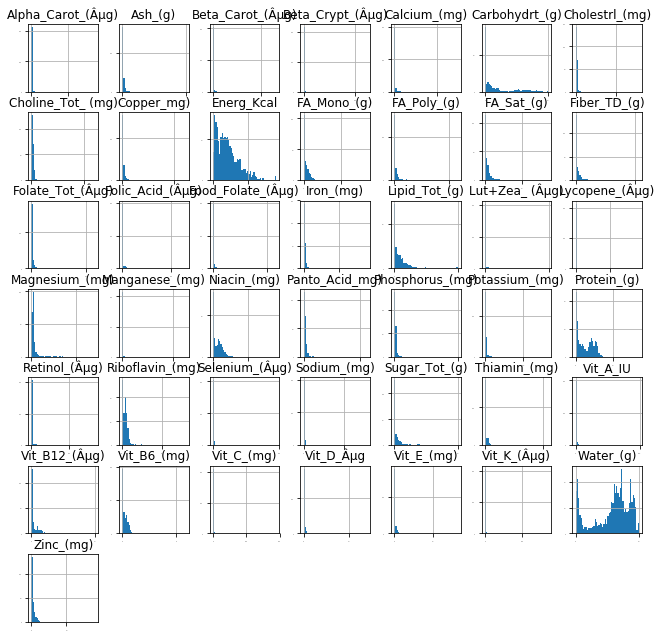

In [17]:
ax = nutr_df.hist(bins=50, xlabelsize=-1, ylabelsize=-1, figsize=(11,11))

Not a bell curve in sight. Worse, a lot of the data is clumped at or around 0. We will use the Box-Cox Transformation on the data, but it requires strictly positive input, so we will add 1 to every value in each column.

In [18]:
nutr_df = nutr_df + 1

Now for the transformation. The [Box-Cox Transformation](https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/) performs the transformation $y(\lambda) = \dfrac{y^{\lambda}-1}{\lambda}$ for $\lambda \neq 0$ and $y(\lambda) = log y$ for $\lambda = 0$ for all values $y$ in a given column. SciPy has a particularly useful `boxcox()` function that can automatically calculate the $\lambda$ for each column that best normalizes the data in that column. (However, it is does not support `NaN` values; scikit-learn has a comparable `boxcox()` function that is `NaN`-safe, but it is not available on the version of scikit-learn that comes with Azure notebooks.)

In [19]:
from scipy.stats import boxcox

nutr_df_TF = pd.DataFrame(index=nutr_df.index)
for col in nutr_df.columns.values:
    nutr_df_TF['{}_TF'.format(col)] = boxcox(nutr_df.loc[:, col])[0]

Let's now take a look at the `DataFrame` containing the transformed data.

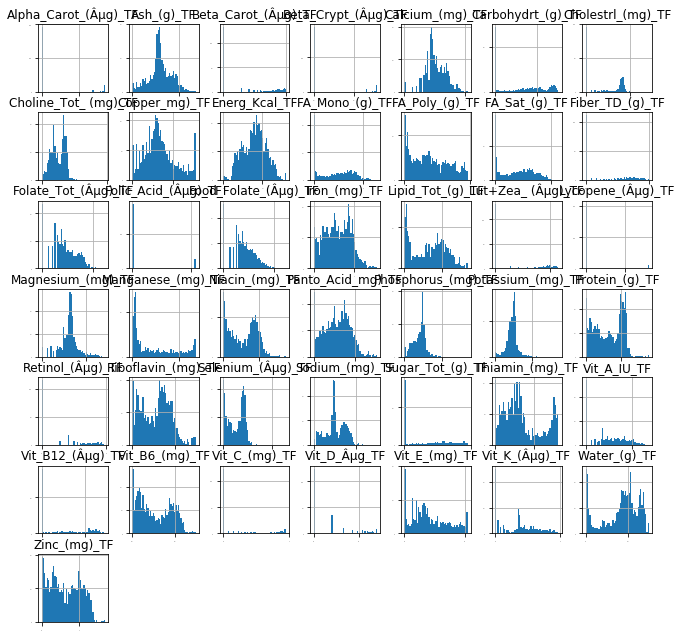

In [20]:
ax = nutr_df_TF.hist(bins=50, xlabelsize=-1, ylabelsize=-1, figsize=(11,11))

Few of these columns looks properly normal, but it is enough to now center the data.

Our data units were incompatible to begin with, and the transformations have not improved that. But we can address that by centering the data around 0; that is, we will again transform the data, this time so that every column has a mean of 0 and a standard deviation of 1. Scikit-learn has a convenient function for this.

In [21]:
nutr_df_TF = StandardScaler().fit_transform(nutr_df_TF)

You can satisfy your self that the data is now centered by using the `mean()` method on the `DataFrame`.

In [22]:
print("mean: ", np.round(abs(nutr_df_TF.mean()), 2))

mean:  0.0


> **Exercise**
>
> Find the standard deviation for the `nutr_df_TF`. (If you need a hint as to which method to use, see [this page](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html).)

In [23]:
print("s.d.: ", np.round(nutr_df_TF.std(), 2))

s.d.:  1.0


> **Exercise solution**
>
> The correct code to use here is `print("s.d.: ", np.round(nutr_df_TF.std(), 2))`.

## PCA in practice

It is finally time to perform the PCA on our data. (As stated before, even with pretty clean data, a lot of effort has to go into preparing the data for analysis.)

In [24]:
fit = PCA()
pca = fit.fit_transform(nutr_df_TF)

So, now that we have performed the PCA on our data, what do we actually have? Remember that PCA is foremost about finding the eigenvectors for our data. We then want to select some subset of those vectors to form the lower-dimensional subspace in which to analyze our data.

Not all of the eigenvectors are created equal. Just a few of them will account for the majority of the variance in the data. (Put another way, a subspace composed of just a few of the eigenvectors will retain the majority of the information from our data.) We want to focus on those vectors.

To help us get a sense of how many vectors we should use, consider this scree graph of the variance for the PCA components, which plots the variance explained by the components from greatest to least.

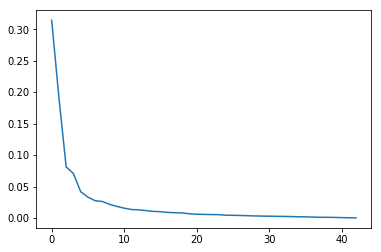

In [25]:
plt.plot(fit.explained_variance_ratio_)

This is where data science can become an art. As a rule of thumb, we want to look for "elbow" in the graph, which is the point at which the few components have captured the majority of the variance in the data (after that point, we are only adding complexity to the analysis for increasingly diminishing returns). In this particular case, that appears to be at about five components.

We can take the cumulative sum of the first five components to see how much variance they capture in total.

In [26]:
print(fit.explained_variance_ratio_[:5].sum())

0.6998599762716344


So our five components capture about 70 percent of the variance. We can see what fewer or additional components would yield by looking at the cumulative variance for all of the components.

In [27]:
print(fit.explained_variance_ratio_.cumsum())

[0.31427328 0.50592605 0.58725445 0.65790094 0.69985998 0.73306959
 0.76058757 0.78686042 0.80856174 0.82704048 0.84268438 0.85623303
 0.86920214 0.88102937 0.89156926 0.90166235 0.91054636 0.91900343
 0.92709175 0.93385062 0.93993572 0.94566278 0.95116044 0.95653205
 0.96101821 0.96533821 0.9694181  0.97312722 0.97646728 0.97953211
 0.98246063 0.98517824 0.9876946  0.99000148 0.99201253 0.99389209
 0.99541908 0.99661961 0.9977484  0.99873972 0.9993591  0.99983003
 1.        ]


We can also examine this visually.

Text(0.5,1,'Cumulative Explained Variance Graph')

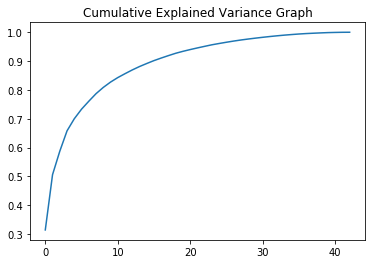

In [28]:
plt.plot(np.cumsum(fit.explained_variance_ratio_))
plt.title("Cumulative Explained Variance Graph")

Ultimately, it is a matter of judgment as to how many components to use, but five vectors (and 70 percent of the variance) will suffice for our purposes in this section.

To aid further analysis, let's now put those five components into a DataFrame.

In [32]:
pca_df = pd.DataFrame(pca[:, :5], index=desc_df.index)
pca_df.head()

,0,1,2,3,4
NDB_No,,,,,
1001,-0.555546,-1.505790,6.702793,2.342886,1.220440
1002,-1.546083,-0.449361,6.714724,3.818746,1.871954
1003,-2.153483,-3.386737,7.661698,1.456534,3.746811
1004,3.478079,0.171293,1.768920,2.996483,-1.874145
1005,2.557895,-0.278522,2.670310,2.878214,-1.738544


Each column represents one of the eigenvectors, and each row is one of the coordinates that defines that vector in five-dimensional space.

We will want to add the FoodGroup column back in to aid with our interpretation of the data later on. Let's also rename the component-columns $c_{1}$ through $c_{5}$ so that we know what we are looking at.

In [33]:
pca_df = pca_df.join(desc_df)
pca_df.drop(['Shrt_Desc', 'GmWt_Desc1', 'GmWt_2', 'GmWt_Desc2', 'Refuse_Pct'], 
            axis=1, inplace=True)
pca_df.rename(columns={0:'c1', 1:'c2', 2:'c3', 3:'c4', 4:'c5'}, 
              inplace=True)
pca_df.head()

,c1,c2,c3,c4,c5,FoodGroup
NDB_No,,,,,,
1001,-0.555546,-1.505790,6.702793,2.342886,1.220440,Dairy and Egg Products
1002,-1.546083,-0.449361,6.714724,3.818746,1.871954,Dairy and Egg Products
1003,-2.153483,-3.386737,7.661698,1.456534,3.746811,Dairy and Egg Products
1004,3.478079,0.171293,1.768920,2.996483,-1.874145,Dairy and Egg Products
1005,2.557895,-0.278522,2.670310,2.878214,-1.738544,Dairy and Egg Products


Don't worry that the FoodGroup column has all `NaN` values: it is not a vector, so it has no vector coordinates.

One last thing we should demonstrate is that each of the components is mutually perpendicular (or orthogonal in math-speak). One way of expressing that condition is that each component-vector should perfectly correspond with itself and not correlate at all (positively or negatively) with any other vector.

In [34]:
np.round(pca_df.corr(), 5)

,c1,c2,c3,c4,c5
c1,1.0,-0.0,0.0,-0.0,0.0
c2,-0.0,1.0,-0.0,0.0,-0.0
c3,0.0,-0.0,1.0,-0.0,-0.0
c4,-0.0,0.0,-0.0,1.0,0.0
c5,0.0,-0.0,-0.0,0.0,1.0


## Interpreting the results

What do our vectors mean? Put another way, what kinds of foods populate the differnt clusters we have discovered among the data?

To see these results, we will create pandas Series for each of the components, index them by feature, and then sort them in descreasing order (so that a higher number represents a feature that is positively correlated with that vector and negative numbers represent low correlation).

In [44]:
vects = fit.components_[:5]

In [45]:
c1 = pd.Series(vects[0], index=nutr_df.columns)
c1.sort_values(ascending=False)

Protein_(g)          0.253011
Selenium_(Âµg)       0.237214
Zinc_(mg)            0.233275
Choline_Tot_ (mg)    0.227019
Phosphorus_(mg)      0.224003
Niacin_(mg)          0.212308
Riboflavin_(mg)      0.206798
Panto_Acid_mg)       0.205353
Cholestrl_(mg)       0.202130
FA_Mono_(g)          0.199087
Lipid_Tot_(g)        0.197132
Vit_B12_(Âµg)        0.196320
Vit_B6_(mg)          0.193737
FA_Sat_(g)           0.192418
Iron_(mg)            0.162307
FA_Poly_(g)          0.161677
Energ_Kcal           0.159268
Ash_(g)              0.146991
Magnesium_(mg)       0.143715
Potassium_(mg)       0.142175
Thiamin_(mg)         0.138838
Vit_D_Âµg            0.138423
Retinol_(Âµg)        0.115504
Sodium_(mg)          0.104025
Copper_mg)           0.095703
Calcium_(mg)         0.058003
Vit_E_(mg)           0.040701
Food_Folate_(Âµg)    0.017723
Folate_Tot_(Âµg)     0.016790
Folic_Acid_(Âµg)     0.001449
Manganese_(mg)      -0.035053
Vit_K_(Âµg)         -0.035386
Vit_A_IU            -0.051647
Lycopene_(

Our first cluster is defined by foods that are high in protein and minerals like selenium and zinc while also being low in sugars and vitamin C. Even to a non-specialist, these sound like foods such as meat, poultry, or legumes.

> **Key takeaway:** Particularly when it comes to interpretation, subject-matter expertise can prove essential to producing high-quality analysis. For this reason, you should also try to include SMEs in your data-science projects.

In [46]:
c2 = pd.Series(vects[1], index=nutr_df.columns)
c2.sort_values(ascending=False)

Manganese_(mg)       0.298009
Fiber_TD_(g)         0.291384
Folate_Tot_(Âµg)     0.272273
Carbohydrt_(g)       0.257291
Food_Folate_(Âµg)    0.241234
Copper_mg)           0.225446
Magnesium_(mg)       0.213403
Calcium_(mg)         0.199649
Lut+Zea_ (Âµg)       0.194307
Sugar_Tot_(g)        0.183276
Ash_(g)              0.181539
Vit_E_(mg)           0.178778
Vit_K_(Âµg)          0.178267
Iron_(mg)            0.175137
Folic_Acid_(Âµg)     0.161876
Thiamin_(mg)         0.147750
Beta_Carot_(Âµg)     0.144678
Energ_Kcal           0.137560
FA_Poly_(g)          0.126692
Potassium_(mg)       0.125701
Vit_C_(mg)           0.101272
Alpha_Carot_(Âµg)    0.089881
Sodium_(mg)          0.084379
Phosphorus_(mg)      0.083271
Beta_Crypt_(Âµg)     0.075684
Riboflavin_(mg)      0.072510
Vit_A_IU             0.064685
Lycopene_(Âµg)       0.053394
Lipid_Tot_(g)        0.053251
Panto_Acid_mg)       0.033587
FA_Mono_(g)          0.027734
FA_Sat_(g)           0.010743
Niacin_(mg)          0.000861
Zinc_(mg) 

Our second group is foods that are high in fiber and folic acid and low in cholesterol.

> **Exercise**
>
> Find the sorted output for $c_{3}$, $c_{4}$, and $c_{5}$.
>
> ***Hint:*** Remember that Python uses zero-indexing.

Even without subject-matter expertise, it is possible to get a more accurate sense of the kinds of foods are defined by each component? Yes! This is the reason we merged the `FoodGroup` column back into `pca_df`. We will sort that `DataFrame` by the components and count the values from `FoodGroup` for the top items.

In [47]:
pca_df.sort_values(by='c1')['FoodGroup'][:500].value_counts()

Vegetables and Vegetable Products    189
Fruits and Fruit Juices              110
Beverages                             70
Sweets                                41
Soups, Sauces, and Gravies            34
Baby Foods                            31
Fats and Oils                          8
Spices and Herbs                       5
Dairy and Egg Products                 4
Breakfast Cereals                      3
Cereal Grains and Pasta                2
Restaurant Foods                       1
Nut and Seed Products                  1
Baked Products                         1
Name: FoodGroup, dtype: int64

We can do the same thing for $c_{2}$.

In [2]:
pca_df.sort_values(by='c1')['FoodGroup'][:500].value_counts()

NameError: name 'pca_df' is not defined

> **Exercise**
>
> Repeat this process for $c_{3}$, $c_{4}$, and $c_{5}$.